# CDIPS lightcurves

Jack Dinsmore, July 2020

This is practice accessing the CDIPS project. Access the [CDIPS](https://archive.stsci.edu/hlsp/cdips#section-65c131d0-9994-46e6-a370-af9f2e3669cc) project. The article presenting it is [here](https://iopscience-iop-org.libproxy.mit.edu/article/10.3847/1538-4365/ab4a7e).

In [1]:
%matplotlib inline
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from tess_stars2px import tess_stars2px_function_entry as tess_stars2px
import os

LIGHTKURVE_CACHE = "/home/jtdinsmo/.lightkurve-cache/tesscut/"
FFI_SIZE_PIXELS = 180

CLUSTER = "NGC 6231"

COORDS = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 2391": (130.133, -53.033), 
          "NGC 6231":(253.53546, -41.82667), "Lambda Orionis":(83.784490, 9.934156), "NGC 3532":(166.44923, -58.7705),
          "Collinder 140":("111.113000", "-31.850000"),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "NGC 6752": (287.71575, -59.98185)}

Error initializing plugin EntryPoint(name='Windows (alt)', value='keyrings.alt.Windows', group='keyring.backends').
Traceback (most recent call last):
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/keyring/backend.py", line 203, in _load_plugins
    init_func = ep.load()
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/importlib_metadata/__init__.py", line 105, in load
    module = import_module(match.group('module'))
  File "/usr/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_

Find all the tess stars within 0.5 degrees of the cluster with magnitude greater than 13.

In [2]:
coords = SkyCoord(COORDS[CLUSTER][0], COORDS[CLUSTER][1], unit='deg')

catalogData = Catalogs.query_region(coords, radius = "0.5 deg", catalog="TIC")
catalogData = catalogData[catalogData["Tmag"] < 13]

TimeoutError: Timeout limit of 600 exceeded.

In [ ]:
print(len(catalogData))

NUM_STARS = 100

strippedCatalogData = catalogData.argsort("Tmag")
strippedCatalogData = catalogData[strippedCatalogData]
strippedCatalogData = strippedCatalogData[:NUM_STARS]
print(len(strippedCatalogData))

Find all the CDIPS lightcurves and remove those that don't correspond to a TIC star with magnitude > 13.

In [ ]:
obs_table = Observations.query_criteria(objectname=CLUSTER, radius="0.2 deg", provenance_name="CDIPS")
print(obs_table.columns)

ANGLE_ERROR = 0.0001

print(len(obs_table))
i = 0
while i < len(obs_table):
    starFound = False
    for j in range(len(strippedCatalogData['ra'])):
        if abs(obs_table[i]['s_ra'] - strippedCatalogData[j]['ra']) <= ANGLE_ERROR:
            if abs(obs_table[i]['s_dec'] - strippedCatalogData[j]['dec']) <= ANGLE_ERROR:
                starFound = True
                break
    if not starFound:
        del obs_table[i]
        i -= 1
    i += 1
        
print(len(obs_table))

Download lightcurves

In [ ]:
cdips_products = Observations.get_product_list(obs_table)
manifest = Observations.download_products(cdips_products)

In [ ]:
print(len(manifest))

Display the sum of the light curves

Counting all the stars:


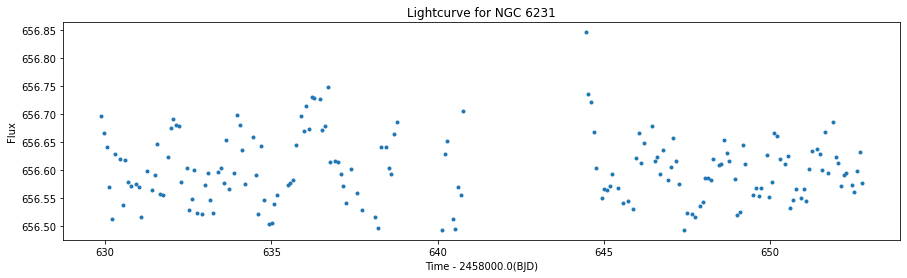

In [192]:
fig, ax = plt.subplots(ncols=1, figsize=(15, 4))

# Get the time range
NUM_MANIFESTS = 200


hdu = fits.open(manifest[1]['Local Path'])
minTime = min(hdu[1].data['TMID_BJD'])
maxTime = max(hdu[1].data['TMID_BJD'])

for i in range(min(len(manifest), NUM_MANIFESTS)):
    try:
        hdu = fits.open(manifest[i]['Local Path'])
        minTime = max(min(hdu[1].data['TMID_BJD']), minTime)
        maxTime = min(max(hdu[1].data['TMID_BJD']), maxTime)
    except:
        pass
    
if len(manifest) < NUM_MANIFESTS:
    print("Counting all the stars:")
else:
    print("Counting {0} / {1} stars:".format(NUM_MANIFESTS, len(manifest)))

BIN_WIDTH = 0.08

# Set up the bins
times = []
counter = minTime
timeOrigin = (minTime // 1000) * 1000
while counter < maxTime:
    times.append(counter - timeOrigin)
    counter+= BIN_WIDTH
times.append(maxTime - timeOrigin)

fluxes = [0] * len(times)

# Add all the light curves
for i in range(min(len(manifest), NUM_MANIFESTS)):
    for j in range(len(hdu[1].data['TMID_BJD'])):
        timeIndex = int((hdu[1].data['TMID_BJD'][j] - minTime) / BIN_WIDTH)
        fluxes[timeIndex] += hdu[1].data['PCA1'][j]
        
# Remove all the bins with too little flux
CUTOFF_PERCENTILE = 38.5

i = 0
cutoff = np.percentile(fluxes, CUTOFF_PERCENTILE)
while i < len(fluxes):
    if(fluxes[i] < cutoff):
        del fluxes[i]
        del times[i]
        i-=1
    i+= 1

ax.scatter(times, fluxes, marker='.')
ax.set_xlabel('Time - ' + str(timeOrigin) + '(BJD)');
ax.set_ylabel('Flux');
ax.set_title("Lightcurve for {0}".format(CLUSTER));

## Show the star positions on the TPF

In [161]:
class Cluster:
    def __init__(self, name):
        self.name = name
        self.clusterRA = COORDS[self.name][0]
        self.clusterDec = COORDS[self.name][1]
        
        # Two primary data products
        self.getTPF()
        self.frame = self.tpf.flux.shape[0]//2
      
    
    def getTPF(self):
        for file in os.listdir(LIGHTKURVE_CACHE):
            if file.endswith("180x180_astrocut.fits"): # Confirm size
                if self.clusterRA == float(file.split("_")[-4]): # Confirm RA
                    if self.clusterDec == float(file.split("_")[-3]): # Confirm dec
                        self.tpf = lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
    
    
    def getPixelPos(self, starRA, starDec, starTIC):        
        sector = self.tpf.header['sector']
        
        star_dat = tess_stars2px(starTIC, starRA, starDec, trySector=sector)
        colStarPix = star_dat[6]
        rowStarPix = star_dat[7]
        
        cluster_dat = tess_stars2px(6789998212, self.clusterRA, self.clusterDec, trySector=sector)# What is this?
        colClusterPix = cluster_dat[6]
        rowClusterPix = cluster_dat[7]
        
        x = int((colStarPix - colClusterPix) + FFI_SIZE_PIXELS // 2)
        y = int((rowStarPix - rowClusterPix) + FFI_SIZE_PIXELS // 2)
        
        return (x, y)
        
    def displayTPF(self):
        image = self.tpf.flux[self.frame]
        
        fig, ax1 = plt.subplots(ncols=1, figsize=(11,11))
        c = ax1.imshow(image, vmax = np.nanpercentile(image, 95));
        ax1.set_title(CLUSTER + " tpf")
        plt.colorbar(c, ax=ax1)
        return ax1

Trim the `strippedCatalogData` so that it only contains stars which have CDIPS light curves. Note: any stars that were trimmed were trimmed because CDIPS did not investigate them; they may have been responsible for any lightcurve variation.

In [166]:
cdipsCatalogData = strippedCatalogData[:]

print(len(cdipsCatalogData))
i = 0
while i < len(cdipsCatalogData):
    starFound = False
    for j in range(len(obs_table['s_ra'])):
        if abs(obs_table[j]['s_ra'] - cdipsCatalogData[i]['ra']) <= ANGLE_ERROR:
            if abs(obs_table[j]['s_dec'] - cdipsCatalogData[i]['dec']) <= ANGLE_ERROR:
                starFound = True
                break
    if not starFound:
        del cdipsCatalogData[i]
        i -= 1
    i += 1
        
print(len(cdipsCatalogData))

100
17


Display all the stars which have high luminosity and CDIPS lightcurves attached.

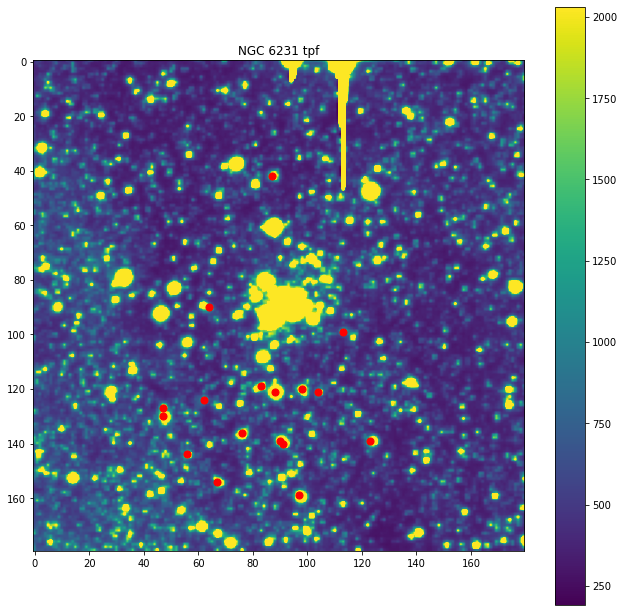

In [167]:
cluster = Cluster(CLUSTER)
ax1 = cluster.displayTPF()

for i in range(len(cdipsCatalogData)):
    ra = cdipsCatalogData[i]["ra"]
    dec = cdipsCatalogData[i]["dec"]
    ticid = cdipsCatalogData[i]["ID"]
    
    x, y = cluster.getPixelPos(ra, dec, ticid)
    ax1.scatter(x, y, s=50, c='r')